Select kernel `segment-anything`

Run this cell to import necessary packages and initialise SAM model and mask generator

In [5]:
# Import the necessary libraries
import numpy as np 
import torch
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import cv2
from ultralytics import YOLO
from PIL import Image
import os
import shutil
from sklearn.model_selection import train_test_split
from IPython.display import display
from IPython.display import clear_output
import yaml
from ultralytics import YOLO
import glob
import pickle

from sam2yolo_functions import *

from jupyter_bbox_widget import BBoxWidget
import ipywidgets as widgets
import os
import json
import base64

sam_checkpoint = "../models/sam_vit_b_01ec64.pth" # Path to the checkpoint file
model_type = 'vit_b' # Model type

device = "cuda" if torch.cuda.is_available() else "cpu" # Use GPU if available, otherwise use CPU

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint) # Load the model
sam.to(device=device) # Move the model to the device

mask_generator = SamAutomaticMaskGenerator(sam) # Create a mask generator
mask_predictor = SamPredictor(sam) # Create a mask predictor

In [10]:
img_path = '../images/dog.jpg'

In [6]:
# helper function that loads an image before adding it to the widget

import base64

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

In [11]:
widget = BBoxWidget(
    image = encode_image(img_path),
    classes=['plane', 'airtug']
)

widget


BBoxWidget(classes=['plane', 'airtug'], colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564…

In [13]:
widget.bboxes

[{'x': 10, 'y': 213, 'width': 415, 'height': 313, 'label': 'plane'}]

In [14]:
import numpy as np

# default_box is going to be used if you will not draw any box on image above
default_box = {'x': 68, 'y': 247, 'width': 555, 'height': 678, 'label': ''}

box_list = []

for box in widget.bboxes:
    box = np.array([ # convert the box to a numpy array
        box['x'],
        box['y'],
        box['x'] + box['width'],
        box['y'] + box['height']
    ])
    box_list.append(box)

import cv2
import numpy as np
import supervision as sv

image_bgr = cv2.imread(img_path) # read the image
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB) # convert the image to RGB

mask_predictor.set_image(image_rgb) # set the image for the mask predictor
predict_list = [] # initialise the predict list

for box in box_list:
    masks, scores, logits = mask_predictor.predict(
        box=box,
        multimask_output=True
    )
    predict_list.append([masks, scores, logits, box]) # append the masks, scores, logits and box to the predict list

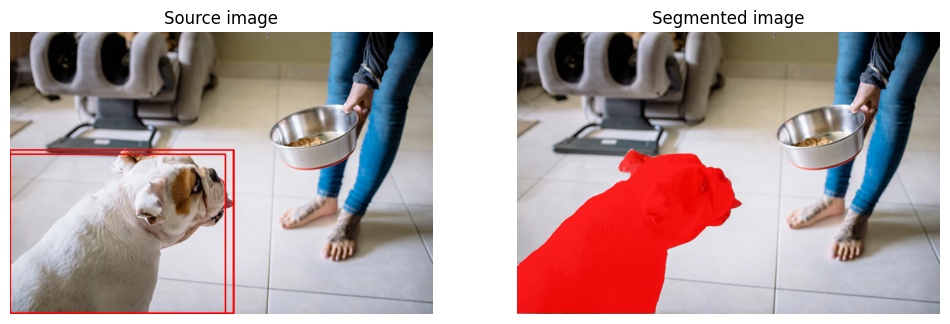

In [15]:
box_annotator = sv.BoxAnnotator(color=sv.Color.red()) # initialise the box annotator
mask_annotator = sv.MaskAnnotator(color=sv.Color.red()) # initialise the mask annotator

detections_list = [] # initialise the detections list

for predictions in predict_list:
    detections = sv.Detections(
        xyxy = sv.mask_to_xyxy(masks=predictions[0]), # convert the masks to xyxy format
        mask = predictions[0]
    )

    detections_list.append(detections) # append the detections to the detections list

for detections in detections_list:
    source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections, skip_label=True) # annotate the image with the boxes
    segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections) # annotate the image with the masks

    sv.plot_images_grid(
        images=[source_image, segmented_image],
        grid_size=(1, 2),
        titles=['Source image', 'Segmented image']
    )




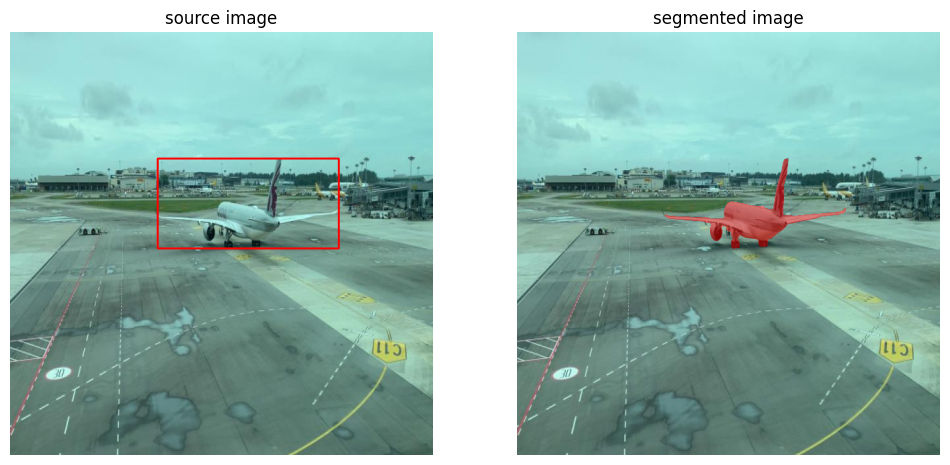

In [123]:
box_annotator = sv.BoxAnnotator(color=sv.Color.red()) # initialise the box annotator
mask_annotator = sv.MaskAnnotator(color=sv.Color.red()) # initialise the mask annotator

detections = sv.Detections( # initialise the detections
    xyxy=sv.mask_to_xyxy(masks=masks), # convert the masks to xyxy format
    mask=masks # add the masks to the detections
)
detections = detections[detections.area == np.max(detections.area)] # get the largest detection

source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections, skip_label=True) # annotate the image with the box
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections) # annotate the image with the mask

sv.plot_images_grid( # plot the images
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)